In [1]:
import sys
print(sys.version)

import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest

from src.detectors import LSHiForest
from data_loader import DataLoader

3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]


In [2]:
# dataのロード:unsw
loader = DataLoader()
X_train, y_train, X_test, y_test = loader.load_unsw_nb15()

print(len(X_train))
print(len(X_test))

175341
82332


In [3]:
# 先行研究で実験
num_ensemblers = 100
classifiers = [("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), ("ALSH", LSHiForest('ALSH', num_ensemblers)), ("L2SH", LSHiForest('L2SH', num_ensemblers)), ("L1SH", LSHiForest('L1SH', num_ensemblers)) ]


for i, (clf_name, clf) in enumerate(classifiers):
	
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time
	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, y_pred)
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.669289221145614
	Training time:	 0.12092781066894531
	Testing time:	 0.14566516876220703

ALSH:
	AUC score:	 0.6714242936795438
	Training time:	 19.862242937088013
	Testing time:	 94.47920989990234

L2SH:
	AUC score:	 0.6474277176673717
	Training time:	 18.465217113494873
	Testing time:	 88.60415601730347

L1SH:
	AUC score:	 0.6365668947536611
	Training time:	 16.783871173858643
	Testing time:	 58.016932010650635



Training and Predicting with sklearn.ISO...

Training and Predicting with ALSH...

Training and Predicting with L2SH...

Training and Predicting with L1SH...

--- All predictions are stored in results_df ---


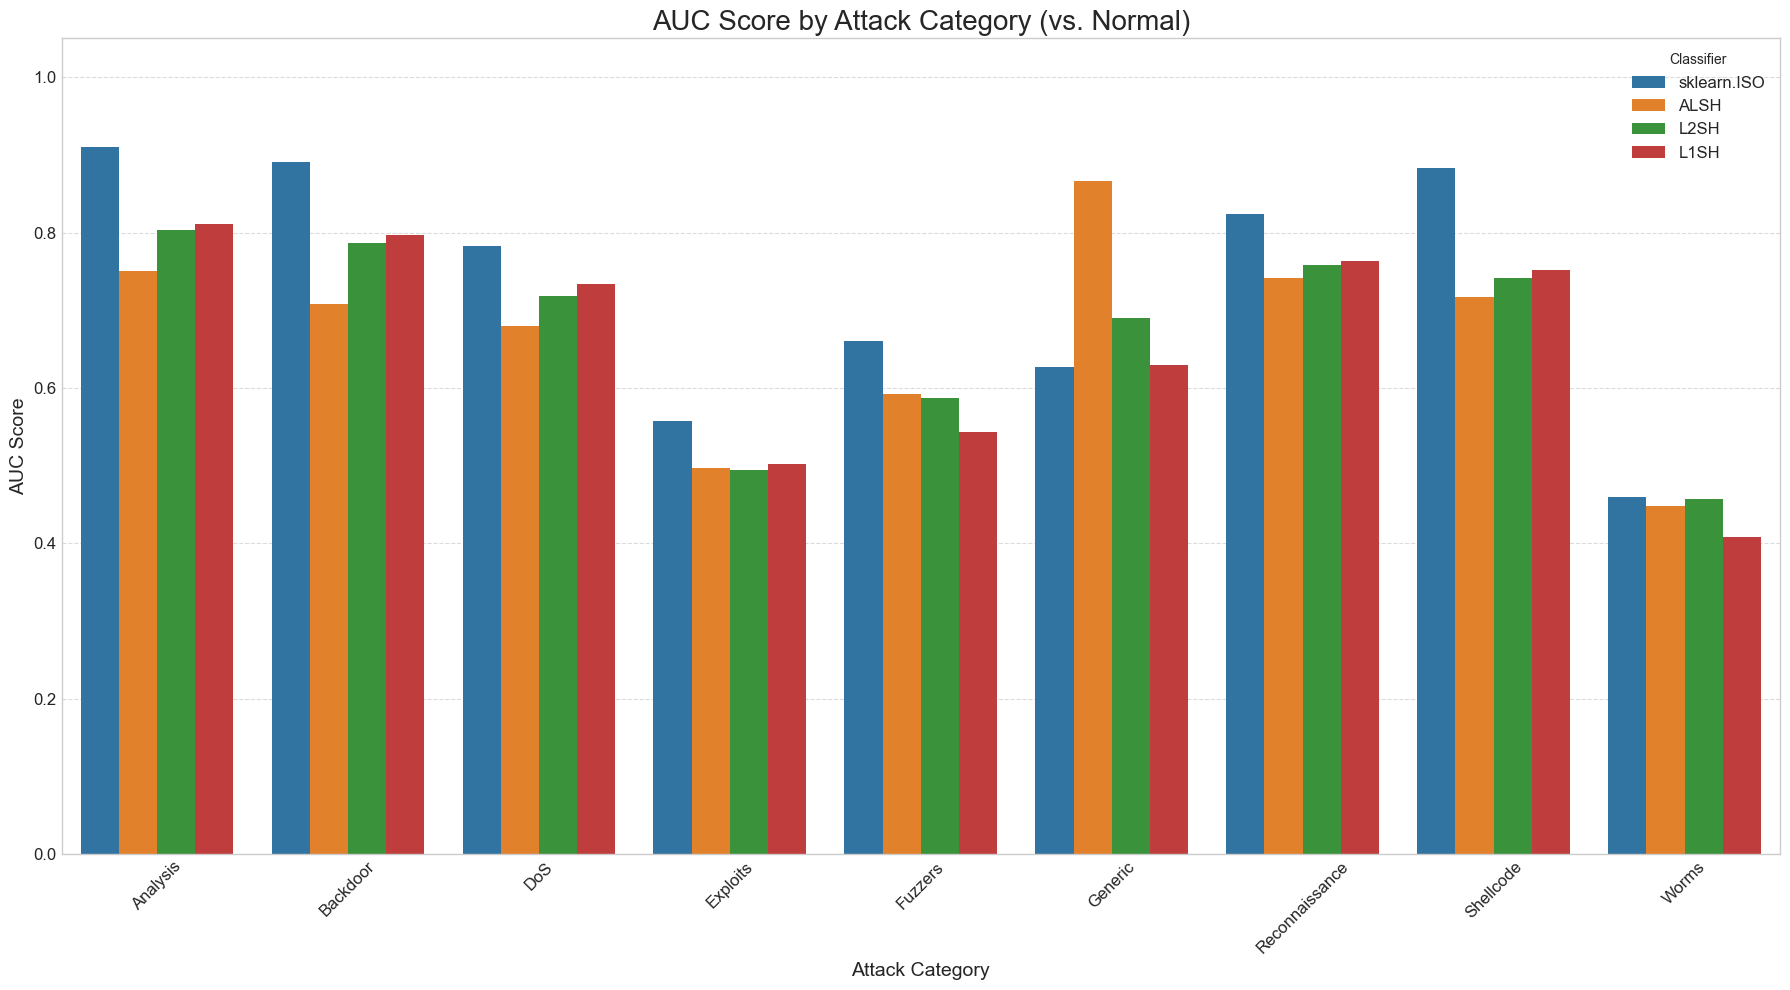

Corrected AUC Scores (Each Attack vs. Normal):
                sklearn.ISO   ALSH   L2SH   L1SH
Analysis             0.9108 0.7503 0.8034 0.8118
Backdoor             0.8904 0.7084 0.7864 0.7973
DoS                  0.7835 0.6793 0.7189 0.7335
Exploits             0.5573 0.4977 0.4948 0.5018
Fuzzers              0.6609 0.5923 0.5873 0.5441
Generic              0.6268 0.8662 0.6905 0.6303
Reconnaissance       0.8242 0.7421 0.7590 0.7633
Shellcode            0.8831 0.7175 0.7417 0.7521
Worms                0.4596 0.4488 0.4575 0.4087


In [ ]:
# --- 1. モデルの定義 ---
num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), 
    ("ALSH", LSHiForest('ALSH', num_ensemblers)), 
    ("L2SH", LSHiForest('L2SH', num_ensemblers)), 
    ("L1SH", LSHiForest('L1SH', num_ensemblers))
]

# --- 2. 【重要】予測結果を格納するDataFrameの準備 ---
attack_cat_series = pd.read_csv('data/unsw_nb15/UNSW_NB15_training-set.csv')['attack_cat']

# y_test（0/1ラベル）とattack_cat（攻撃カテゴリ名）でDataFrameを作成
# y_testとattack_cat_seriesの行数が合うようにインデックスを合わせる
results_df = pd.DataFrame({
    'attack_cat': attack_cat_series.values,
    'label': y_test.values
}, index=y_test.index)


# --- 3. モデルの学習・予測・結果の保存 ---
if results_df is not None:
    # X_testは数値データのみなので、そのまま予測に使用。
    for clf_name, clf in classifiers:
        print(f"\nTraining and Predicting with {clf_name}...")
        clf.fit(X_train)
        y_pred = clf.decision_function(X_test)
        results_df[f'pred_{clf_name}'] = y_pred

    normal_df = results_df[results_df['label'] == 0]
    attack_df = results_df[results_df['label'] == 1]
    
    corrected_auc_scores = {}
    for clf_name, _ in classifiers:
        scores = {}
        unique_attack_cats = sorted(attack_df['attack_cat'].unique())
        for cat in unique_attack_cats:
            current_attack_df = attack_df[attack_df['attack_cat'] == cat]
            eval_df = pd.concat([normal_df, current_attack_df])
            eval_preds = eval_df[f'pred_{clf_name}']
            eval_labels = eval_df['label']
            auc = roc_auc_score(eval_labels, eval_preds)
            scores[cat] = auc
        corrected_auc_scores[clf_name] = scores

    # グラフ描画と結果表示
    plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
    plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax)
    ax.set_title('AUC Score by Attack Category (vs. Normal)', fontsize=20)
    ax.set_xlabel('Attack Category', fontsize=14)
    ax.set_ylabel('AUC Score', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(title='Classifier', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("Corrected AUC Scores (Each Attack vs. Normal):")
    pd.options.display.float_format = '{:.4f}'.format
    results_table = pd.DataFrame(corrected_auc_scores)
    print(results_table)

In [ ]:
# データの準備:nsl
loader = DataLoader()
X_train, y_train, X_test, y_test = loader.load_nsl_kdd()

print(len(X_train))
print(len(X_test))

125973
22544


In [ ]:
#　先行研究での実験
num_ensemblers = 100
classifiers = [("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), ("ALSH", LSHiForest('ALSH', num_ensemblers)), ("L2SH", LSHiForest('L2SH', num_ensemblers)), ("L1SH", LSHiForest('L1SH', num_ensemblers)) ]


for i, (clf_name, clf) in enumerate(classifiers):
	
	print("\n"+clf_name+":")
	start_time = time.time()
	
	clf.fit(X_train)
	
	train_time = time.time()-start_time

	y_pred = clf.decision_function(X_test)

	if clf_name == "sklearn.ISO":
		y_pred = -y_pred

	
	test_time = time.time()-start_time-train_time
	
	auc = roc_auc_score(y_test, y_pred)
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.8705230743809745
	Training time:	 0.11416387557983398
	Testing time:	 0.04626798629760742

ALSH:


/Users/daisukesugata/kenkyu/src_LSHiForest/src/detectors/lsh_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key]-mean)/std), cur_index+1)


	AUC score:	 0.4156570054983314
	Training time:	 13.11435317993164
	Testing time:	 23.6586697101593

L2SH:


/Users/daisukesugata/kenkyu/src_LSHiForest/src/detectors/lsh_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key]-mean)/std), cur_index+1)


	AUC score:	 0.777734815606868
	Training time:	 13.059646844863892
	Testing time:	 11.943267107009888

L1SH:


/Users/daisukesugata/kenkyu/src_LSHiForest/src/detectors/lsh_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key]-mean)/std), cur_index+1)


	AUC score:	 0.7836096838466482
	Training time:	 11.509105920791626
	Testing time:	 11.21344804763794



Training and Predicting with sklearn.ISO...

Training and Predicting with ALSH...


/Users/daisukesugata/kenkyu/src_LSHiForest/src/detectors/lsh_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key]-mean)/std), cur_index+1)



Training and Predicting with L2SH...


/Users/daisukesugata/kenkyu/src_LSHiForest/src/detectors/lsh_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key]-mean)/std), cur_index+1)



Training and Predicting with L1SH...


/Users/daisukesugata/kenkyu/src_LSHiForest/src/detectors/lsh_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key]-mean)/std), cur_index+1)



--- All predictions are stored in results_df ---


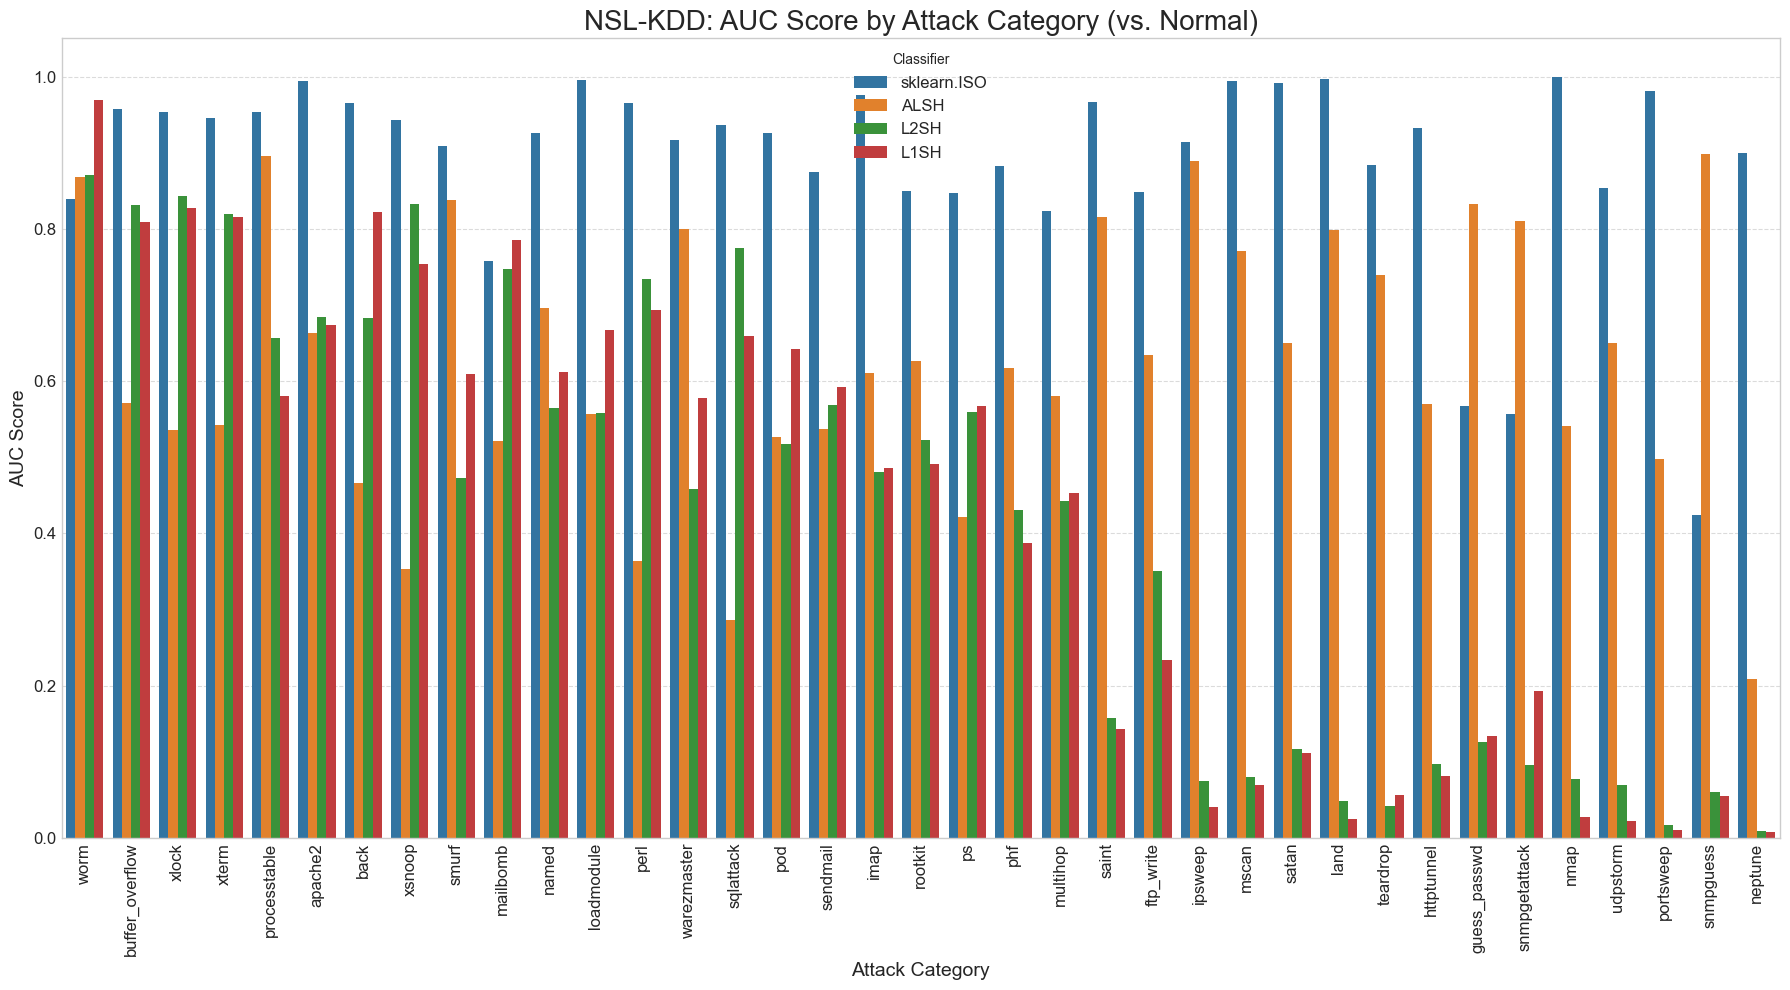


Corrected AUC Scores for NSL-KDD (Each Attack vs. Normal):
Attack Category  worm  buffer_overflow  xlock  xterm  processtable  apache2  \
apache2           NaN              NaN    NaN    NaN           NaN      NaN   
back              NaN              NaN    NaN    NaN           NaN      NaN   
buffer_overflow   NaN              NaN    NaN    NaN           NaN      NaN   
ftp_write         NaN              NaN    NaN    NaN           NaN      NaN   
guess_passwd      NaN              NaN    NaN    NaN           NaN      NaN   
httptunnel        NaN              NaN    NaN    NaN           NaN      NaN   
imap              NaN              NaN    NaN    NaN           NaN      NaN   
ipsweep           NaN              NaN    NaN    NaN           NaN      NaN   
land              NaN              NaN    NaN    NaN           NaN      NaN   
loadmodule        NaN              NaN    NaN    NaN           NaN      NaN   
mailbomb          NaN              NaN    NaN    NaN           NaN     

In [ ]:
# 攻撃手法別に分析？

# --- 1. モデルの定義 (変更なし) ---
num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)),
    ("ALSH", LSHiForest('ALSH', num_ensemblers)),
    ("L2SH", LSHiForest('L2SH', num_ensemblers)),
    ("L1SH", LSHiForest('L1SH', num_ensemblers))
]

# --- 2.【重要】NSL-KDDの攻撃カテゴリ名を取得し、予測結果を格納するDataFrameを準備 ---
results_df_created = False
try:
    test_df_for_cat = pd.read_csv('data/nsl-kdd/KDDTest+.txt', header=None)
    
    # カラム名はdata_loader.pyの定義に合わせます。
    columns = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
        'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
        'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
        'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
        'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
        'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
        'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
        'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate', 'dst_host_srv_serror_rate',
        'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack',
        'difficulty'
    ]
    test_df_for_cat.columns = columns
    # attack列の値を空白除去
    attack_cat_series = test_df_for_cat['attack'].str.strip()
    results_df_created = True
except FileNotFoundError:
    print("Error: 'data/nsl_kdd/KDDTest+.txt' が見つかりません。ファイルパスを確認してください。")


if results_df_created:
    # y_test（0/1ラベル）とattack_cat（攻撃カテゴリ名）でDataFrameを作成
    results_df = pd.DataFrame({
        'attack_cat': attack_cat_series.values,
        'label': y_test.values
    }, index=y_test.index)

    # --- 3. モデルの学習・予測・結果の保存 ---
    for clf_name, clf in classifiers:
        print(f"\nTraining and Predicting with {clf_name}...")
        clf.fit(X_train)
        y_pred = clf.decision_function(X_test)
        results_df[f'pred_{clf_name}'] = y_pred
    print("\n--- All predictions are stored in results_df ---")

    # --- 4. カテゴリ別AUCの計算 ---
    normal_df = results_df[results_df['label'] == 0]
    attack_df = results_df[results_df['label'] == 1]

    corrected_auc_scores = {}
    for clf_name, _ in classifiers:
        scores = {}
        unique_attack_cats = sorted([cat for cat in attack_df['attack_cat'].unique() if cat != 'normal'])
        for cat in unique_attack_cats:
            current_attack_df = attack_df[attack_df['attack_cat'] == cat]
            eval_df = pd.concat([normal_df, current_attack_df])
            eval_preds = eval_df[f'pred_{clf_name}']
            eval_labels = eval_df['label']
            
            if len(eval_labels.unique()) > 1:
                auc = roc_auc_score(eval_labels, -eval_preds)
                scores[cat] = auc
            else:
                scores[cat] = None
        corrected_auc_scores[clf_name] = scores

    # --- 5. グラフ描画と結果表示 ---
    plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
    plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()

    # カテゴリごとの平均AUCを算出し、降順でカテゴリの順序を決定
    category_order = plot_df_melted.groupby('Attack Category')['AUC Score'].mean().sort_values(ascending=False).index

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 10))
    # order引数に決定した順序を指定
    sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax, order=category_order)
    
    ax.set_title('NSL-KDD: AUC Score by Attack Category (vs. Normal)', fontsize=20)
    ax.set_xlabel('Attack Category', fontsize=14)
    ax.set_ylabel('AUC Score', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', labelrotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(title='Classifier', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('nsl_kdd_auc_by_category.png')
    plt.show()

    print("\nCorrected AUC Scores for NSL-KDD (Each Attack vs. Normal):")
    pd.options.display.float_format = '{:.4f}'.format
    # テーブルもグラフの順序に合わせて表示
    results_table = pd.DataFrame(corrected_auc_scores).reindex(category_order, axis=1) 
    print(results_table)